In [46]:
import pandas as pd
import numpy as np
import wfdb
import ast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

DB_ROOT = 'data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'

In [2]:
SCP_LABELS = {
    'SR': 'sinus rhythm',
    'SARRH': 'sinus arrhythmia',
    'SBRAD': 'bradycardia',
    'STACH': 'sinus tachycardia',
    'AFIB': 'artrial fibrillation',
}

Причесываем данные и анализируем их

In [3]:
Y = pd.read_csv(f'{DB_ROOT}/ptbxl_database.csv')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Split scp labels into separate columns
for scp_label in SCP_LABELS.keys():
    Y[scp_label] = Y.scp_codes.apply(lambda x: int(scp_label in x))

# If one of the illnesses or normal
Y['labels_cnt'] = Y[SCP_LABELS.keys()].sum(axis=1)
Y['has_label'] = Y.labels_cnt > 0

Y.head(2)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,SR,SARRH,SBRAD,STACH,AFIB,labels_cnt,has_label
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0,1,True
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0,0,1,0,0,1,True


Проверяем сбалансированность классов и считаем, как часто встречаются несколько labels.

In [4]:
def count_nonzero(x):
    return np.sum(x > 0)

Y[['strat_fold', 'has_label', 'ecg_id'] + list(SCP_LABELS.keys())].groupby(['strat_fold', 'has_label']).agg(count_nonzero).reset_index()

,strat_fold,has_label,ecg_id,SR,SARRH,SBRAD,STACH,AFIB
0,1,False,126,0,0,0,0,0
1,1,True,2051,1678,77,63,82,151
2,2,False,131,0,0,0,0,0
3,2,True,2053,1678,77,64,83,151
4,3,False,144,0,0,0,0,0
5,3,True,2050,1678,77,63,82,151
6,4,False,121,0,0,0,0,0
7,4,True,2054,1679,77,64,83,151
8,5,False,121,0,0,0,0,0
9,5,True,2055,1679,78,64,83,152


Видим, что SR слишком много, оставим в каждом фолде по 100 ЭКГ со статусом SR

In [5]:
def get_random_n(obj, n, replace=False, seed=123):
    np.random.seed(seed)
    return obj.loc[np.random.choice(obj.index, n, replace), :]
    
SR_ecgids = Y[Y.SR == 1].groupby('strat_fold', as_index=False).apply(lambda r: get_random_n(r, 100))['ecg_id'].values

In [6]:
Y = Y[(Y.SR == 0) | (Y.ecg_id.isin(SR_ecgids))]
Y[['strat_fold', 'has_label', 'ecg_id'] + list(SCP_LABELS.keys())].groupby(['strat_fold', 'has_label']).agg(count_nonzero).reset_index()

,strat_fold,has_label,ecg_id,SR,SARRH,SBRAD,STACH,AFIB
0,1,False,126,0,0,0,0,0
1,1,True,473,100,77,63,82,151
2,2,False,131,0,0,0,0,0
3,2,True,475,100,77,64,83,151
4,3,False,144,0,0,0,0,0
5,3,True,472,100,77,63,82,151
6,4,False,121,0,0,0,0,0
7,4,True,475,100,77,64,83,151
8,5,False,121,0,0,0,0,0
9,5,True,476,100,78,64,83,152


In [7]:
# How many ecg examples with more than 1 label
print(f"ECG-examples with more than 1 label: {Y[Y.labels_cnt > 1].shape[0]}")
Y[Y.labels_cnt > 1][['report', 'scp_codes']]

ECG-examples with more than 1 label: 3


,report,scp_codes
283,"sinus bradycardia with sinus arrhythmia. the cause of the bradycardia is not evident. voltages are high in chest leads suggesting lvh. st segments are depressed in i, ii, avl, v4,5,6. this may be ...","{'LVH': 100.0, 'ISC_': 100.0, 'DIG': 100.0, 'VCLVH': 0.0, 'STD_': 0.0, 'SBRAD': 0.0, 'SARRH': 0.0}"
10362,"sinus bradycardia with sinus arrhythmia. the bradycardia may be physiological. st segments are elevated in i, ii, avf, v2-6, this is probably a normal variant. high v lead voltages are probably...","{'NORM': 100.0, 'SBRAD': 0.0, 'SARRH': 0.0}"
12282,sinus bradycardia with sinus arrhythmia. otherwise normal ecg. the cause of the bradycardia is not evident.,"{'NORM': 80.0, 'SBRAD': 0.0, 'SARRH': 0.0}"


In [101]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Print(nn.Module):
    def forward(self, x):
        print(f'printtt: {x.size()}')
        return x

class SimpleECGClassifier:
    def __init__(self, print_layer=False):
        # input: [n, 12, 1000]
        self.model = nn.Sequential()
        if print_layer:
            self.model.add_module('p1', Print())
        self.model.add_module('conv1', nn.Conv1d(in_channels=12, out_channels=24, kernel_size=17, stride=2))
        self.model.add_module('bn1', nn.BatchNorm1d(24))
        # input: [n, 24, 492]
        if print_layer:
            self.model.add_module('p2', Print())
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('conv2', nn.Conv1d(in_channels=24, out_channels=48, kernel_size=10, stride=2))
        self.model.add_module('bn2', nn.BatchNorm1d(48))
        # input: [n, 48, 242]
        if print_layer:
            self.model.add_module('p3', Print())
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('conv3', nn.Conv1d(in_channels=48, out_channels=96, kernel_size=10, stride=2))
        self.model.add_module('bn3', nn.BatchNorm1d(96))
        # input: [n, 96, 117]
        if print_layer:
            self.model.add_module('p4', Print())
        self.model.add_module('mp', nn.MaxPool1d(3, stride=2))
        # input: [n, 96, 58]
        if print_layer:
            self.model.add_module('p45', Print())
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('flatten1', Flatten())
        #self.model.add_module('p5', Print())
        self.model.add_module('dense1', nn.Linear(5568, 100))
        #self.model.add_module('p6', Print())
        self.model.add_module('relu4', nn.ReLU())
        self.model.add_module('dense2', nn.Linear(100, 25)) # layer to add meta-features
        #self.model.add_module('p7', Print())
        self.model.add_module('relu5', nn.ReLU())
        self.model.add_module('dense3', nn.Linear(25, 5))
        #self.model.add_module('p8', Print())
        self.model.add_module('sigmoid', nn.Sigmoid())
        
        self.criterion = torch.nn.BCELoss()
        self.opt = torch.optim.Adam(self.model.parameters(), lr=0.001)
    
    def fit(self, X, y):
        self.model.train()
        self.opt.zero_grad()        
        prediction = self.model(X)
        loss = self.criterion(prediction, y)
        print(loss)
        loss.backward()
        self.opt.step()
    
#     def set_lr(self, )
                              
    def predict(self, X):
        self.model.eval()
        prediction = self.model(X)
        return prediction

Формируем входные данные с помощью функции из примера для данного датасета

In [9]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f"{path}/{f}") for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f"{path}/{f}") for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

X = load_raw_data(Y, 100, DB_ROOT)

Готовим данные для train/validation/test датасетов

In [122]:
def iter_batch(X, Y):
    for fold in sorted(Y.strat_fold.unique()):
        X_batch_train = X[np.where(Y.strat_fold == fold)]
        Y_batch_train = Y[Y.strat_fold == fold]
        yield X_batch_train, Y_batch_train

test_fold = 10 # from the dataset recommendations

# Train dataset
X_train = X[np.where(Y.strat_fold != test_fold)]
Y_train = Y[Y.strat_fold != test_fold]

# Test dataset
X_test = X[np.where(Y.strat_fold == test_fold)]
Y_test = Y[Y.strat_fold == test_fold]

In [16]:
def multiclass_accuracy(y, pred):
    y = y.detach().numpy()
    pred = pred.detach().numpy()
    pred = np.rint(pred)
    return sum((np.rint(y) == pred).all(axis=1)) / y.shape[0]

In [124]:
EPOCHS = 100
model_1 = SimpleECGClassifier()

# plt.figure()
# plt.title('Train/validation accuracy curves', fontsize=20)
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")

X_test_T = torch.Tensor(np.transpose(X_test, [0, 2, 1]))
y_test_T = torch.Tensor(Y_test[SCP_LABELS].values)

train_acc_1 = []
test_acc_1 = []

train_acc_curr_1 = []

for epoch in range(0, EPOCHS):
    print(f'EPOCH {epoch}')
    if epoch > 0:
        train_acc_1.append(np.mean(train_acc_curr_1))
        pred_test_1 = model_1.predict(X_test_T)
        test_acc_1.append(multiclass_accuracy(pred_test_1, y_test_T))
        print(f'Avg train accuracy: {train_acc_1[-1]}')
        print(f'Test accuracy: {test_acc_1[-1]}')
    
    train_acc_curr_1 = []
        
    for (X_batch_train, Y_batch_train) in iter_batch(X_train, Y_train):
        X_batch_train = torch.Tensor(np.transpose(X_batch_train, [0, 2, 1]))
        y_batch_train = torch.Tensor(Y_batch_train[SCP_LABELS].values)
        
        model_1.fit(X_batch_train, y_batch_train)
        pred_train_1 = model_1.predict(X_batch_train)
        train_acc_curr_1.append((multiclass_accuracy(pred_train_1, y_batch_train)))
 
        #plt.plot(i_v, accuracy_train_v)
        #plt.plot(i_v, accuracy_val_v)
        #plt.legend(['Train accuracy', 'Validation accuracy'])
        #display.display(plt.gcf())
        #display.clear_output(wait=True)

EPOCH 0
tensor(0.6866, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4760, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4519, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4424, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4336, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4360, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4272, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4138, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 1
Avg train accuracy: 0.1385774447137813
Test accuracy: 0.2416
tensor(0.4303, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4215, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4230, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4220, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4147, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4070, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4064, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4095, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4033, grad_fn

tensor(0.1653, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1703, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1889, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1698, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1643, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1747, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1758, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1881, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 16
Avg train accuracy: 0.665584403843736
Test accuracy: 0.568
tensor(0.1625, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1527, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1892, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1703, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1674, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1657, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1623, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1662, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1856, grad_fn=<BinaryC

tensor(0.0888, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0807, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0964, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0846, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0825, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0804, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0763, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0762, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0894, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 31
Avg train accuracy: 0.8469751927364823
Test accuracy: 0.5824
tensor(0.0879, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0682, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0861, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0755, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0775, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0774, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0645, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0730, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0879, grad_fn=<Binar

tensor(0.0463, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0345, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0302, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0344, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0368, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0359, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 46
Avg train accuracy: 0.9206921378655422
Test accuracy: 0.5376
tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0473, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0278, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0277, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0302, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0402, grad_fn=<Binar

tensor(0.0144, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0329, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0167, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0080, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0201, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0189, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0079, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0129, grad_fn=<BinaryCrossEntropyBackward>)
EPOCH 61
Avg train accuracy: 0.9508711336210295
Test accuracy: 0.5152
tensor(0.0145, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0453, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0088, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0227, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0475, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0368, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0114, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0138, grad_fn=<Binar

KeyboardInterrupt: 

1.0

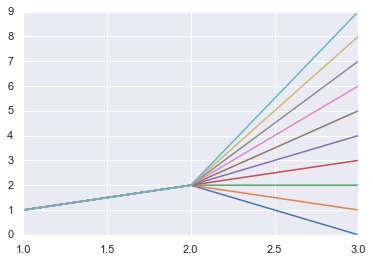

In [61]:
import time
import pylab as pl
from IPython import display

plt.figure()  # create a plot figure

for i in range(10):
    plt.plot([1,2,3], [1,2,i])
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)

In [93]:
loss = nn.CrossEntropyLoss()
input = torch.randn(5, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
loss(input, target)

ValueError: Expected input batch_size (5) to match target batch_size (3).

In [91]:
input

tensor([[ 0.5687, -0.5397,  0.0530, -1.0293,  0.6565],
        [ 0.2682, -0.3047, -1.6836, -0.0933,  1.8159],
        [ 0.8070,  1.3727,  0.9859, -2.1921,  0.7414]], requires_grad=True)

In [92]:
target

tensor([0, 1, 4])